In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1 Import Packages

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import torch.optim as optim

# # This is for the progress bar
# from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt
from torch.utils.data import SubsetRandomSampler

In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split


In [ ]:
import os
import zipfile
from zipfile import ZipFile

zip_file_path = '/content/drive/MyDrive/skin_lesion_xf.zip'
extract_dir = '/content/drive/MyDrive/Deep_learning/extracted_file'

# Check if the files are already extracted
if not (os.path.exists(os.path.join(extract_dir, 'skin_lesion', 'test_isic_2017')) and
        os.path.exists(os.path.join(extract_dir, 'skin_lesion', 'train_balanced')) and
        os.path.exists(os.path.join(extract_dir, 'skin_lesion', 'val_balanced'))):
    # If not, extract the files
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Files extracted successfully.")
else:
    print("Files already extracted in the directory folder.")

Files already extracted in the directory folder.


# 2 Dataset

## 2.1 Download the Skin Lesion Dataset

In [ ]:
# Define the paths to your train, validation, and test folders
train_path = '/content/drive/MyDrive/Deep_learning/extracted_file/skin_lesion/train_balanced'
val_path = '/content/drive/MyDrive/Deep_learning/extracted_file/skin_lesion/val_balanced'
test_path = '/content/drive/MyDrive/Deep_learning/extracted_file/skin_lesion/test_isic_2017'


In [ ]:
# Define image transformations for augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=test_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [ ]:
# Create data loader with the specified sampler
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

# Calculate the sizes of train and evaluation datasets based on the ratios
#train_size = int(train_ratio * len(train_dataset))
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

#print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {train_size} samples')
print(f'Validation set has {(val_size)} samples')
print(f'Test set has {(test_size)} samples')



Train set has 7848 samples
Validation set has 1962 samples
Test set has 600 samples


In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Deep_learning/extracted_file/skin_lesion'

# Define folders and classes
folders = ['train_balanced', 'val_balanced', 'test_isic_2017']
classes = ['mel', 'oth']

# Create a table to store the results
results = [['Folder', 'Class', 'Number of Images']]

# Loop through each folder and class
for folder in folders:
    for label in classes:
        # Construct the path
        path = os.path.join(directory, folder, label)
        try:
            # Count the number of images
            num_images = len(os.listdir(path))
        except FileNotFoundError:
            # If the directory doesn't exist, set the number of images to 0
            num_images = 0
        # Append the result to the table
        results.append([folder, label, num_images])

# Print the results in table format
for row in results:
    print("{: <15} {: <10} {: <15}".format(*row))

Folder          Class      Number of Images
train_balanced  mel        3924           
train_balanced  oth        3924           
val_balanced    mel        981            
val_balanced    oth        981            
test_isic_2017  mel        117            
test_isic_2017  oth        483            


## 2.2 PyTorch Dataset and Dataloader

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.ImageFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

# SHOW SOME SKIN LESION IMAGES

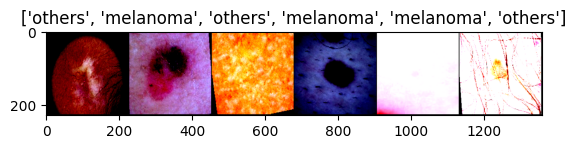

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['melanoma', 'others']

imshow(out, title=[class_names[x] for x in classes])

# 3 Initiate Model, Define Loss and Optimizer

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparameters
num_classes = 2
batch_size = 64
learning_rate = 0.01
num_epochs = 10
dropout_rate = 0.5
momentum = 0.9
patience = 10


In [ ]:
# Define model architectures
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = models.alexnet(pretrained=True).features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# No of classes/Labels
num_classes = 2

# Set up criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()

# Initialize models
alexnet = AlexNet(num_classes).to(device)
alexnet_optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
alexnet_scheduler = ReduceLROnPlateau(alexnet_optimizer, patience=3, verbose=True)

# Initialize models
vgg16 = VGG16(num_classes).to(device)
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)
vgg16_scheduler = ReduceLROnPlateau(vgg16_optimizer, patience=3, verbose=True)


# 5 Train and Validation

In [ ]:
# Assuming train_loader and val_loader are already defined DataLoader objects for training and validation datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import itertools
import copy

# Define training function with memory management
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, n_epochs=10, patience=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(n_epochs):
        # ---------- Training ----------
        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Use mixed precision training
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.cpu().numpy())  # Move tensor to CPU

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.cpu().numpy())  # Move tensor to CPU

        print(f"[Epoch {epoch + 1}/{n_epochs}] Train: loss={epoch_loss:.5f}, acc={epoch_acc:.5f} | Valid: loss={val_loss:.5f}, acc={val_acc:.5f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print('Early stopping!')
            break

        scheduler.step(val_loss)

        # Clear cache after each epoch
        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)

    # Save model weights
    torch.save(model.state_dict(), f'{model.__class__.__name__.lower()}.pth')

    print(f'Best validation accuracy: {best_acc:.4f}')
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming alexnet, vgg16, criterion, alexnet_optimizer, alexnet_scheduler, vgg16_optimizer, vgg16_scheduler are defined

# Train AlexNet
print('Training AlexNet...')
alexnet = alexnet.to(device)
alexnet, alexnet_train_acc_history, alexnet_val_acc_history, alexnet_train_loss_history, alexnet_val_loss_history = train_model(
    alexnet, criterion, alexnet_optimizer, alexnet_scheduler, train_loader, val_loader)

# Train VGG16
print('Training VGG16...')
vgg16 = vgg16.to(device)
vgg16, vgg16_train_acc_history, vgg16_val_acc_history, vgg16_train_loss_history, vgg16_val_loss_history = train_model(
    vgg16, criterion, vgg16_optimizer, vgg16_scheduler, train_loader, val_loader)


Training AlexNet...


100%|██████████| 31/31 [00:07<00:00,  4.20it/s]


[Epoch 1/10] Train: loss=0.40134, acc=0.80772 | Valid: loss=0.40349, acc=0.80785


100%|██████████| 31/31 [00:07<00:00,  4.20it/s]


[Epoch 2/10] Train: loss=0.39697, acc=0.80976 | Valid: loss=0.40126, acc=0.81091


100%|██████████| 31/31 [00:07<00:00,  4.32it/s]


[Epoch 3/10] Train: loss=0.39224, acc=0.81435 | Valid: loss=0.40535, acc=0.81193


100%|██████████| 31/31 [00:07<00:00,  4.20it/s]


[Epoch 4/10] Train: loss=0.39400, acc=0.81256 | Valid: loss=0.40520, acc=0.81244


100%|██████████| 31/31 [00:07<00:00,  4.26it/s]


[Epoch 5/10] Train: loss=0.39471, acc=0.81384 | Valid: loss=0.40145, acc=0.81448


100%|██████████| 31/31 [00:07<00:00,  4.25it/s]


[Epoch 6/10] Train: loss=0.39570, acc=0.81116 | Valid: loss=0.40188, acc=0.81295


100%|██████████| 31/31 [00:07<00:00,  4.28it/s]


[Epoch 7/10] Train: loss=0.39420, acc=0.80657 | Valid: loss=0.40224, acc=0.81295


100%|██████████| 31/31 [00:07<00:00,  4.25it/s]


[Epoch 8/10] Train: loss=0.39515, acc=0.81129 | Valid: loss=0.40232, acc=0.81295


100%|██████████| 31/31 [00:07<00:00,  4.19it/s]


[Epoch 9/10] Train: loss=0.38982, acc=0.81154 | Valid: loss=0.40251, acc=0.81295


100%|██████████| 31/31 [00:07<00:00,  4.23it/s]


[Epoch 10/10] Train: loss=0.39046, acc=0.81231 | Valid: loss=0.40256, acc=0.81295
Best validation accuracy: 0.8145
Training VGG16...


100%|██████████| 31/31 [00:15<00:00,  2.02it/s]


[Epoch 1/10] Train: loss=0.36008, acc=0.83677 | Valid: loss=0.40772, acc=0.81244


100%|██████████| 31/31 [00:15<00:00,  1.95it/s]


[Epoch 2/10] Train: loss=0.36042, acc=0.83168 | Valid: loss=0.41643, acc=0.81142


100%|██████████| 31/31 [00:15<00:00,  1.99it/s]


[Epoch 3/10] Train: loss=0.35768, acc=0.83792 | Valid: loss=0.41239, acc=0.81397


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


[Epoch 4/10] Train: loss=0.35547, acc=0.83843 | Valid: loss=0.41387, acc=0.81295


100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


[Epoch 5/10] Train: loss=0.35202, acc=0.83767 | Valid: loss=0.41497, acc=0.81193


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


[Epoch 6/10] Train: loss=0.36082, acc=0.83244 | Valid: loss=0.41533, acc=0.81193


100%|██████████| 31/31 [00:15<00:00,  1.95it/s]


[Epoch 7/10] Train: loss=0.35277, acc=0.83779 | Valid: loss=0.41581, acc=0.81142


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


[Epoch 8/10] Train: loss=0.35561, acc=0.83716 | Valid: loss=0.41586, acc=0.81142


100%|██████████| 31/31 [00:15<00:00,  1.96it/s]


[Epoch 9/10] Train: loss=0.36265, acc=0.83231 | Valid: loss=0.41588, acc=0.81142


100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


[Epoch 10/10] Train: loss=0.35597, acc=0.83512 | Valid: loss=0.41591, acc=0.81193
Best validation accuracy: 0.8140


# PLOTTING THE TRAINING AND VALIDATION ACCURACY AND LOSS

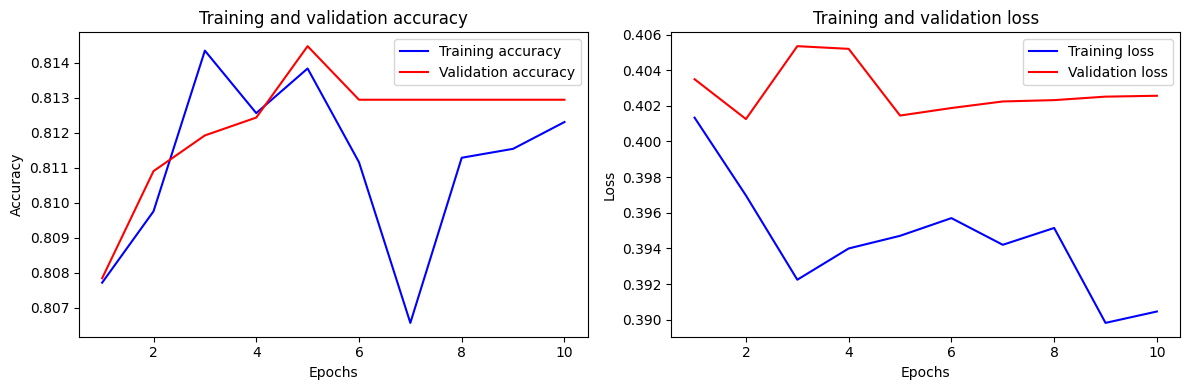

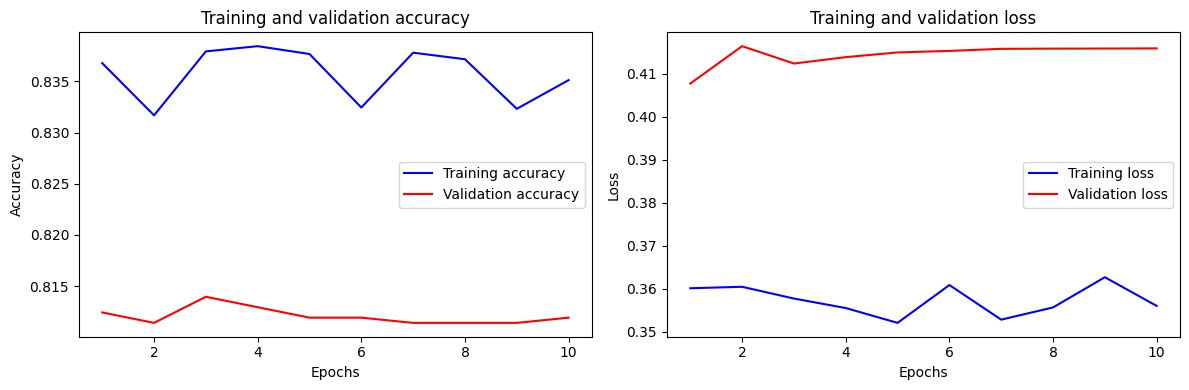

In [ ]:
# Define the plotting function for training and validation history
def plot_train_val_history(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Plot training and validation loss and accuracy for AlexNet
plot_train_val_history(alexnet_train_acc_history, alexnet_val_acc_history, alexnet_train_loss_history, alexnet_val_loss_history)

# Plot training and validation loss and accuracy for VGG16
plot_train_val_history(vgg16_train_acc_history, vgg16_val_acc_history, vgg16_train_loss_history, vgg16_val_loss_history)



# TESTING THE MODELS

In [ ]:
# Function to test the model
def test_model(model, test_loader):
    model.eval()
    corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = nn.functional.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            corrects += torch.sum(preds == labels.data)

    test_acc = corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc:.4f}')
    return all_labels, all_preds, all_probs, test_acc



# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming alexnet, vgg16, criterion, alexnet_optimizer, alexnet_scheduler, vgg16_optimizer, vgg16_scheduler are defined

# # Train AlexNet
# print('Training AlexNet...')
# alexnet = alexnet.to(device)
# alexnet, alexnet_train_acc_history, alexnet_val_acc_history, alexnet_train_loss_history, alexnet_val_loss_history = train_model(
#     alexnet, criterion, alexnet_optimizer, alexnet_scheduler, train_loader, val_loader)

# # Train VGG16
# print('Training VGG16...')
# vgg16 = vgg16.to(device)
# vgg16, vgg16_train_acc_history, vgg16_val_acc_history, vgg16_train_loss_history, vgg16_val_loss_history = train_model(
#     vgg16, criterion, vgg16_optimizer, vgg16_scheduler, train_loader, val_loader)

# Test AlexNet
print('Testing AlexNet...')
alexnet_labels, alexnet_preds, alexnet_probs, alexnet_test_acc = test_model(alexnet, test_loader)

# Test VGG16
print('Testing VGG16...')
vgg16_labels, vgg16_preds, vgg16_probs, vgg16_test_acc = test_model(vgg16, test_loader)


Testing AlexNet...


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Test Accuracy: 0.7367
Testing VGG16...


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

Test Accuracy: 0.6883


# PLOTTING THE CONFUSION MATRIX

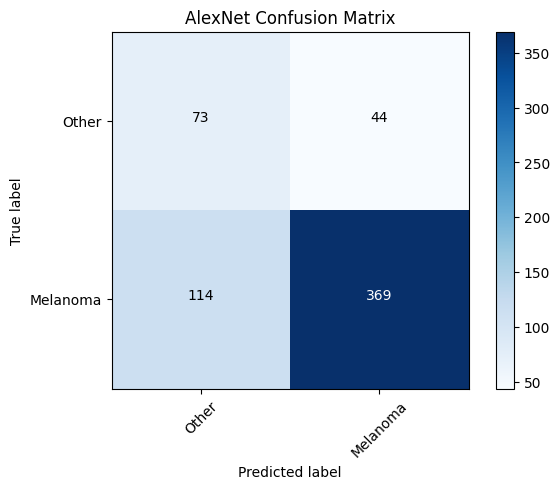

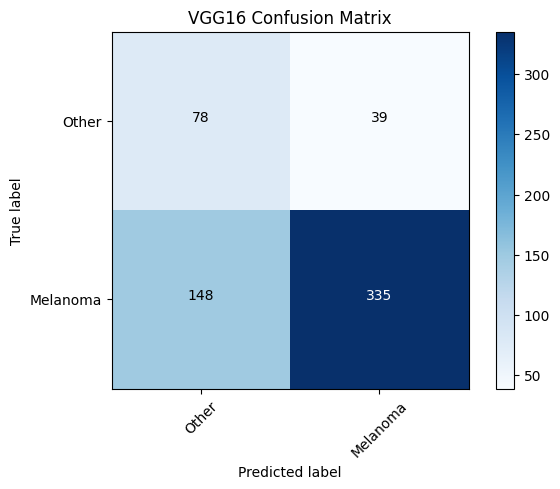

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot confusion matrix for AlexNet
alexnet_cm = confusion_matrix(alexnet_labels, alexnet_preds)
plot_confusion_matrix(alexnet_cm, classes=['Other', 'Melanoma'], title='AlexNet Confusion Matrix')

# Plot confusion matrix for VGG16
vgg16_cm = confusion_matrix(vgg16_labels, vgg16_preds)
plot_confusion_matrix(vgg16_cm, classes=['Other', 'Melanoma'], title='VGG16 Confusion Matrix')


# PLOTTING THE ROC AND AUC

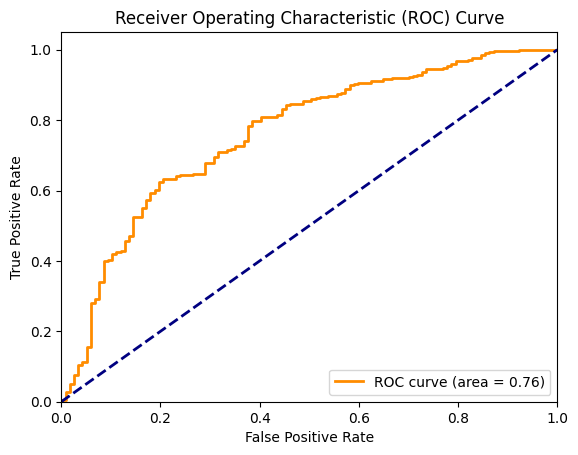

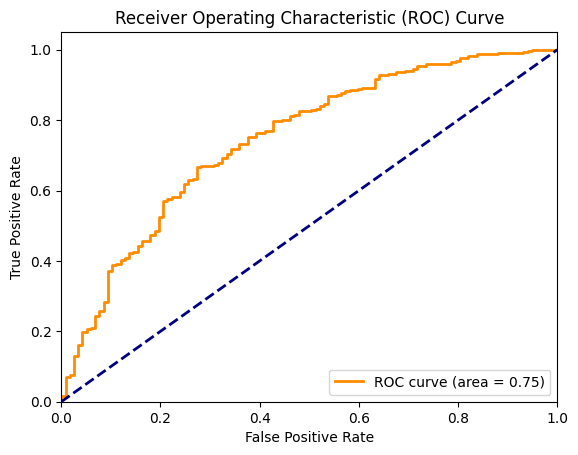

In [ ]:
# Plot ROC and AUC
def plot_roc_auc(labels, probs, n_classes=2):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels, probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[1]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot ROC and AUC for AlexNet
plot_roc_auc(alexnet_labels, np.array(alexnet_probs))

# Plot ROC and AUC for VGG16
plot_roc_auc(vgg16_labels, np.array(vgg16_probs))

# COMPUTE THE PRECISION , RECALL , F1 SCORE

In [ ]:
# Compute precision, recall, and F1 score
def compute_metrics(labels, preds):
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return precision, recall, f1

# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Compute precision, recall, F1 score for AlexNet
alexnet_precision, alexnet_recall, alexnet_f1 = compute_metrics(alexnet_labels, alexnet_preds)
print(f'AlexNet Precision: {alexnet_precision:.4f}, Recall: {alexnet_recall:.4f}, F1 Score: {alexnet_f1:.4f}')

# Compute precision, recall, F1 score for VGG16
vgg16_precision, vgg16_recall, vgg16_f1 = compute_metrics(vgg16_labels, vgg16_preds)
print(f'VGG16 Precision: {vgg16_precision:.4f}, Recall: {vgg16_recall:.4f}, F1 Score: {vgg16_f1:.4f}')



AlexNet Precision: 0.8935, Recall: 0.7640, F1 Score: 0.8237
VGG16 Precision: 0.8957, Recall: 0.6936, F1 Score: 0.7818


# Plot Actual vs Predicted Images

AlexNet - Actual vs Predicted:


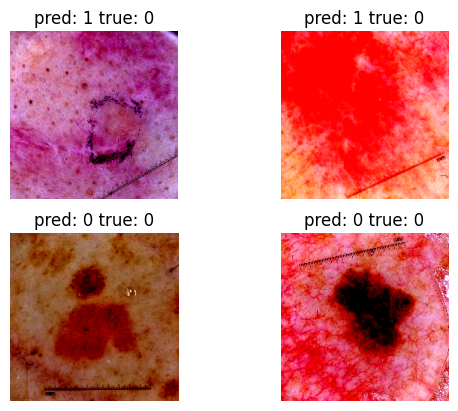

In [ ]:
# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot actual vs predicted images
def plot_actual_vs_predicted(model, dataloader, n_images=4):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(n_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {preds[j].item()} true: {labels[j].item()}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))

                if images_so_far == n_images:
                    return


 # Plot actual vs predicted images for AlexNet
print('AlexNet - Actual vs Predicted:')
plot_actual_vs_predicted(alexnet, test_loader, n_images=4)



VGG16 - Actual vs Predicted:


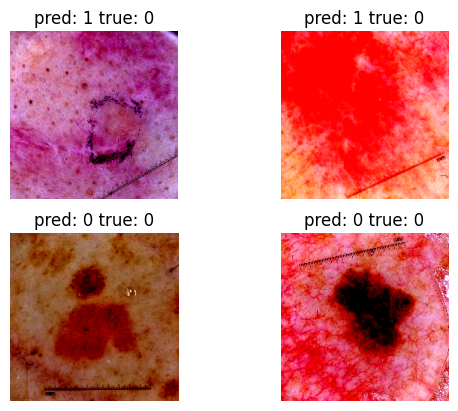

In [ ]:
# Plot actual vs predicted images for VGG16
print('VGG16 - Actual vs Predicted:')
plot_actual_vs_predicted(vgg16, test_loader, n_images=4)

# Ensemble Model and Testing

In [ ]:
# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensemble Averaging of AlexNet and VGG16
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        return (x1 + x2) / 2

# Initialize the ensemble model
ensemble_model = EnsembleModel(alexnet, vgg16)
ensemble_model = ensemble_model.to(device)

# Test Ensemble Model
print('Testing Ensemble Model...')
ensemble_labels, ensemble_preds, ensemble_probs, ensemble_test_acc = test_model(ensemble_model, test_loader)

Testing Ensemble Model...


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

Test Accuracy: 0.7383


# Ensemble Model - Plot Confusion Matrix

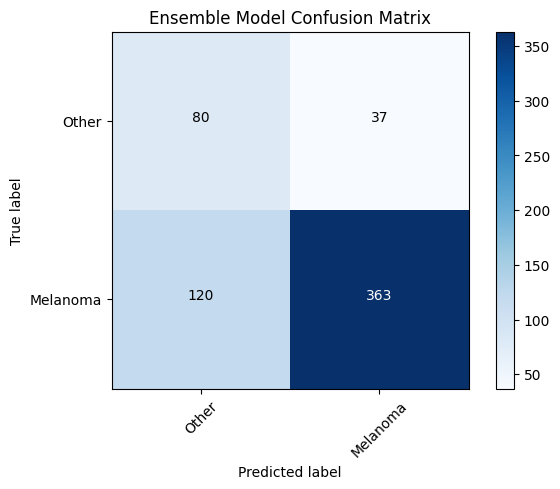

In [ ]:
# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot confusion matrix for Ensemble Model
ensemble_cm = confusion_matrix(ensemble_labels, ensemble_preds)
plot_confusion_matrix(ensemble_cm, classes=['Other', 'Melanoma'], title='Ensemble Model Confusion Matrix')



# Ensemble Model - Plot ROC and AUC

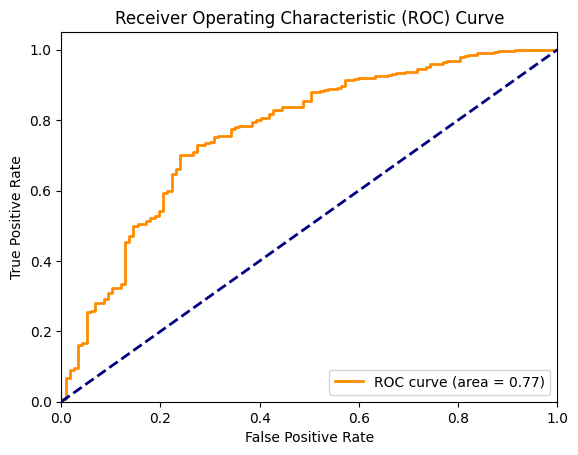

In [ ]:
# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot ROC and AUC for Ensemble Model
plot_roc_auc(ensemble_labels, np.array(ensemble_probs))

# Ensemble Model - Compute Precision, Recall, F1 Score

In [ ]:
# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Compute precision, recall, F1 score for Ensemble Model
ensemble_precision, ensemble_recall, ensemble_f1 = compute_metrics(ensemble_labels, ensemble_preds)
print(f'Ensemble Model Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1 Score: {ensemble_f1:.4f}')


Ensemble Model Precision: 0.9075, Recall: 0.7516, F1 Score: 0.8222


# Ensemble Model - Plot Actual vs Predicted Images

Ensemble Model - Actual vs Predicted:


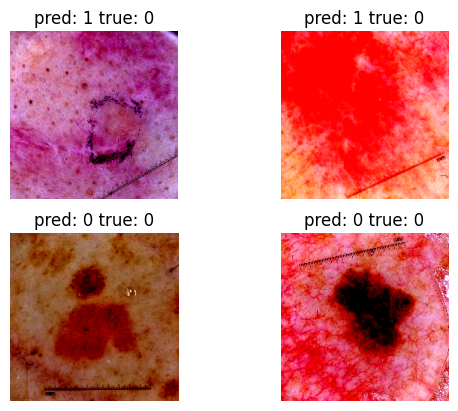

In [ ]:
# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot actual vs predicted images for Ensemble Model
print('Ensemble Model - Actual vs Predicted:')
plot_actual_vs_predicted(ensemble_model, test_loader, n_images=4)


# Randomly Select and Plot Images for Predictions by Ensemble Model

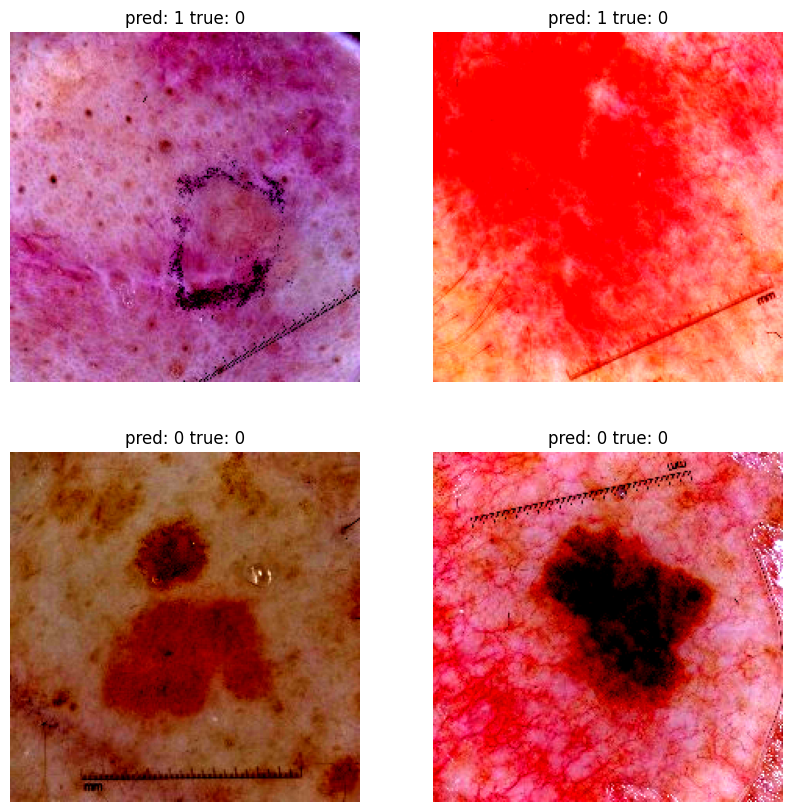

In [ ]:
# Function to plot randomly selected images for predictions by Ensemble Model
def plot_random_predictions(model, dataloader, n_images=4):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(n_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {preds[j].item()} true: {labels[j].item()}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))

                if images_so_far == n_images:
                    return



# Assuming you have defined your dataloaders (train_loader, val_loader, test_loader) and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Plot random predictions for Ensemble Model
plot_random_predictions(ensemble_model, test_loader, n_images=4)